In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
data_dir = '.'

In [32]:
df_data=pd.read_csv("./Data/merged_final_data", sep=',', encoding='latin1', error_bad_lines=False)

d=df_data.loc[:, ~df_data.columns.str.contains('^Unnamed: 0')]
df = d[['SYSBP','DBP','HR','TEMP','WEIGHT','HEIGHT']]
print(df.shape)


(1113, 6)


In [33]:
df.shape
display_step = 5
learning_rate = 0.001


In [34]:
df.head()


,SYSBP,DBP,HR,TEMP,WEIGHT,HEIGHT
0,123.0,89.0,63.0,36.2,58.0,165.0
1,125.0,90.0,80.0,36.1,58.0,0.0
2,125.0,80.0,80.0,36.3,58.0,0.0
3,120.0,85.0,75.0,36.6,58.0,0.0
4,120.0,70.0,75.0,36.3,58.0,0.0


In [35]:
df.dtypes

SYSBP     float64
DBP       float64
HR        float64
TEMP      float64
WEIGHT    float64
HEIGHT    float64
dtype: object

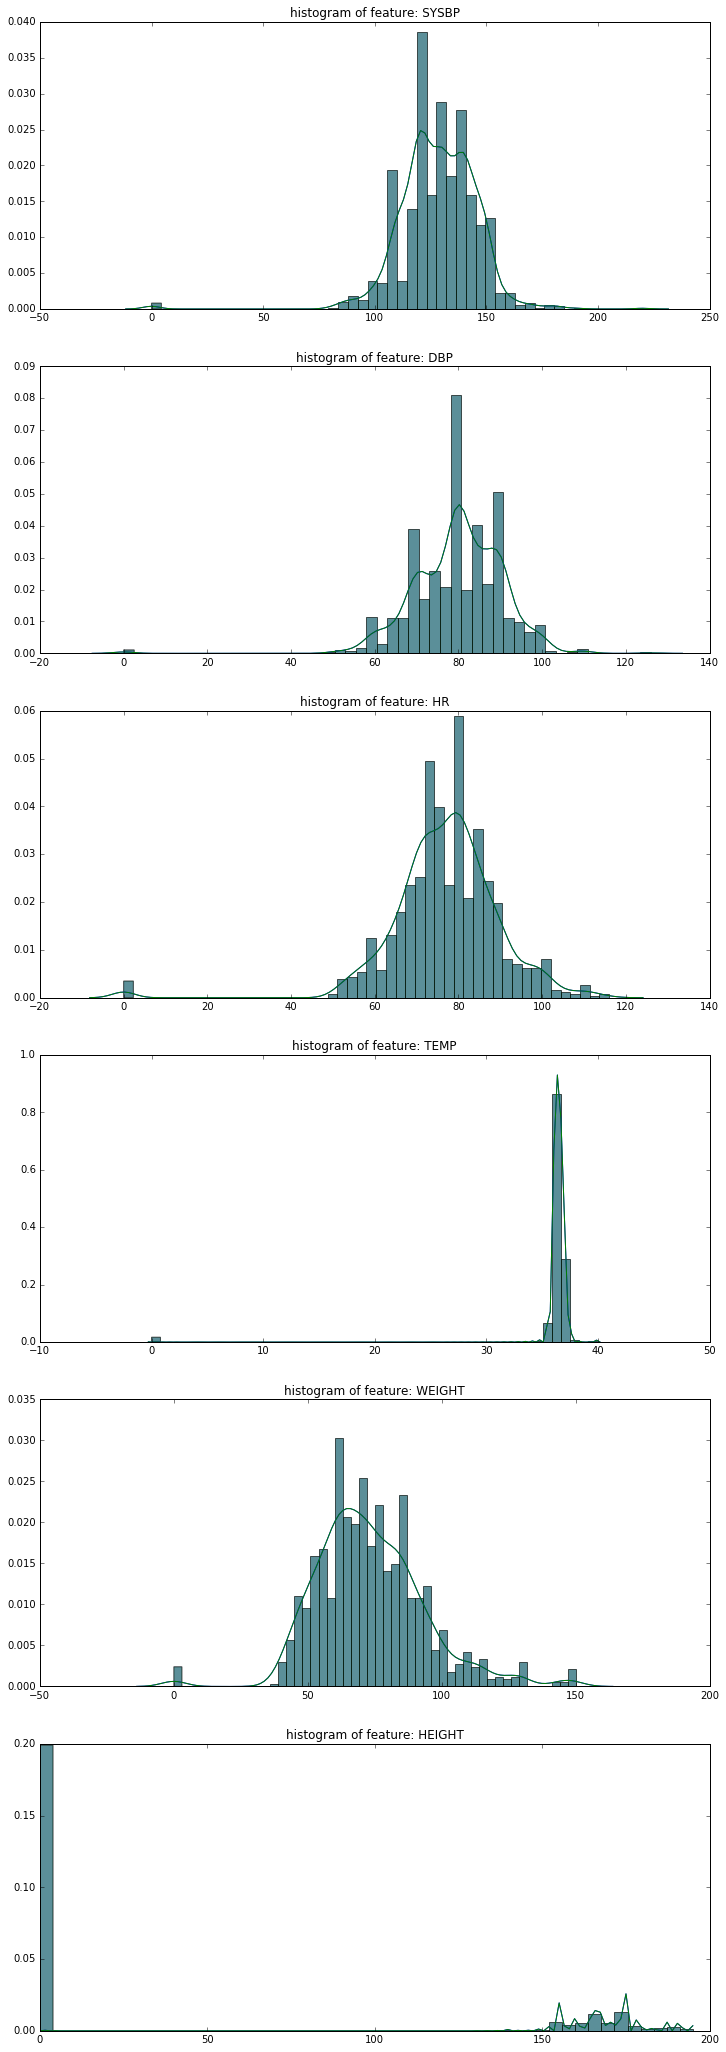

In [36]:
plt.figure(figsize=(12,6*6))
gs = gridspec.GridSpec(6, 1)
for i, cn in enumerate(df.columns):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn], bins=50)
    sns.distplot(df[cn], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

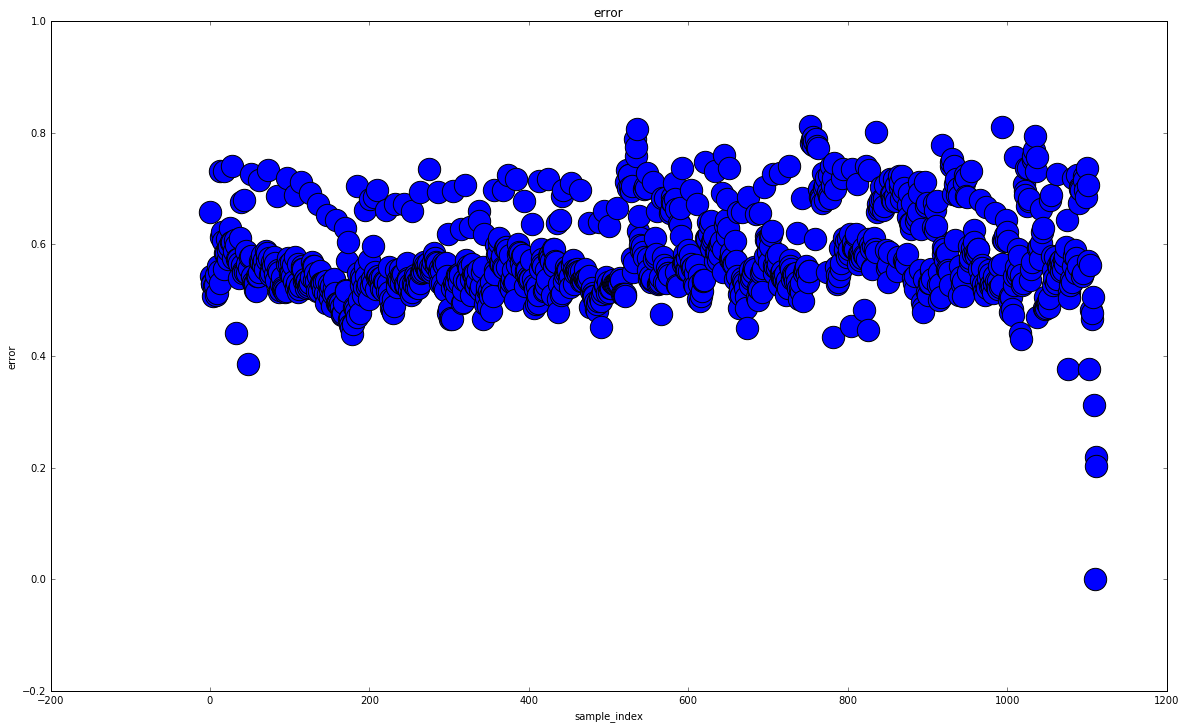

In [37]:
#after normalization
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

datae=scaler.fit_transform(df)
before_out=[np.mean(i) for i in datae]
before_out=pd.DataFrame(before_out)
before_out["sample_index"]=df.index
before_out.columns = ['error', "sample_index"]
# print(before_out)
plt.figure()
before_out.plot(kind="scatter", x="sample_index", y="error", title = "error", s = 500)

In [38]:
epocha=1000
batch_size=35
iterations=int(len(df)//35)
def get_batch(i,batch_size=35):
    batch_slice=df[i*batch_size:(i+1)*batch_size]
#     print([list(i) for i in batch_slice])
    scaler = MinMaxScaler()
    datae=scaler.fit_transform(batch_slice)
#     print("vvlaues",datae)
    return np.array(datae)
#     return [list(i) for i in batch_slice]
scaler = MinMaxScaler()
scal=scaler.fit_transform(df)
scaled_dataset=np.array(scal)

In [10]:
import tensorflow as tf
import numpy as np

input_size=6
hidden_size_1=8
hidden_size_2=3

# fake_data=[]

# for i in range(0,10):
#     fake_data.append(np.random.uniform(0, 3, [1, 784]))
tf.reset_default_graph()

x_data=tf.placeholder(name='Input_data',shape=[None,6],dtype=tf.float32)


weights={ 'encoder_1':tf.get_variable(name='encoder_1',shape=[input_size,hidden_size_1],
                          dtype=tf.float32,initializer=tf.random_uniform_initializer(-0.01,0.01)),
         'encoder_2' : tf.get_variable(name='encoder_2',shape=[hidden_size_1,hidden_size_2],
                          dtype=tf.float32,initializer=tf.random_uniform_initializer(-0.01,0.01)),
         'decoder_1':tf.get_variable(name='decoder_2',shape=[hidden_size_2,hidden_size_1],
                          dtype=tf.float32,initializer=tf.random_uniform_initializer(-0.01,0.01)),
         'decoder_2':tf.get_variable(name='decoder_3',shape=[hidden_size_1,input_size],
                          dtype=tf.float32,initializer=tf.random_uniform_initializer(-0.01,0.01))
          }



bias={ 'e_bias_1':tf.get_variable(name='e_encoder_1',shape=[hidden_size_1],
                          dtype=tf.float32,initializer=tf.random_uniform_initializer(-0.01,0.01)),
      'e_bias_2':tf.get_variable(name='e_encoder_2',shape=[hidden_size_2],
                          dtype=tf.float32,initializer=tf.random_uniform_initializer(-0.01,0.01)),
      'd_bias_1':tf.get_variable(name='e_decoder_2',shape=[hidden_size_1],
                          dtype=tf.float32,initializer=tf.random_uniform_initializer(-0.01,0.01)),
      'd_bias_2':tf.get_variable(name='e_decoder_3',shape=[input_size],
                          dtype=tf.float32,initializer=tf.random_uniform_initializer(-0.01,0.01))
    }



def encoder_network(x):
    
    layer_first=tf.matmul(x,weights['encoder_1'])
    layer_first=tf.add(layer_first,bias['e_bias_1'])
    sigmoid_l=tf.nn.tanh(layer_first)

    layer_second=tf.matmul(sigmoid_l,weights['encoder_2'])
    layer_second=tf.add(layer_second,bias['e_bias_2'])
    return tf.nn.tanh(layer_second)

def decoder_network(y):
    
    decoder_first=tf.matmul(y,weights['decoder_1'])
    decoder_first =tf.add(decoder_first,bias['d_bias_1'])
    sigmoid_d = tf.nn.tanh(decoder_first)

    decoder_second = tf.matmul(sigmoid_d,weights['decoder_2'])
    decoder_second = tf.add(decoder_second,bias['d_bias_2'])
    return tf.nn.tanh(decoder_second)


# Construct model
encoder_op = encoder_network(x_data)
decoder_op = decoder_network(encoder_op)

# Prediction
y_pred = decoder_op

# Targets (Labels) are the input data.
y_true = x_data

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)


# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# TRAIN StARTS
save_model = os.path.join(data_dir, 'tensorflow_model.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
#     total_batch = int(train_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(epocha):
        # Loop over all batches
        for i in range(iterations):
            
            
#             batch_idx = np.random.choice(train_x.shape[0], batch_size)
            batch_xs = get_batch(i)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x_data: batch_xs})
            
        # Display logs per epoch step
        if epoch % 5 == 0:
            
            train_batch_mse = sess.run(batch_mse, feed_dict={x_data: scaled_dataset})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c),
                  "mse {}".format(train_batch_mse),
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    
    
    
    

Epoch: 0001 cost= 0.325340956 mse [ 0.41594195  0.33877018  0.32339492 ...,  0.00149466  0.15087152
  0.10855784] Time elapsed= 0:00:00.245710
Epoch: 0006 cost= 0.103084527 mse [ 0.0912096   0.044166    0.04159762 ...,  0.11639109  0.14254184
  0.12003104] Time elapsed= 0:00:00.461188
Epoch: 0011 cost= 0.099689990 mse [ 0.08542002  0.04216639  0.03993775 ...,  0.07920434  0.1322955
  0.10901639] Time elapsed= 0:00:00.678037
Epoch: 0016 cost= 0.096809015 mse [ 0.07779639  0.04069975  0.03911032 ...,  0.02295388  0.118109    0.08831609] Time elapsed= 0:00:00.910287
Epoch: 0021 cost= 0.094354711 mse [ 0.07115632  0.03811542  0.03718096 ...,  0.00162141  0.10757694
  0.07810034] Time elapsed= 0:00:01.149525
Epoch: 0026 cost= 0.093045026 mse [ 0.0691236   0.03694292  0.0362033  ...,  0.01529044  0.10642707
  0.07801938] Time elapsed= 0:00:01.360365
Epoch: 0031 cost= 0.092443705 mse [ 0.06797576  0.03702512  0.03627759 ...,  0.01826135  0.10671744
  0.07656453] Time elapsed= 0:00:01.586392
E

In [ ]:
# plt.figure()
# df=df
# print(df)
# # df.plot(kind="scatter", x="sample_index", y="Reconstruction.MSE", 
# #         title = "reconstruction error", s = 500)


In [11]:
import h2o
h2o.init()


def get_iqr(df_data):
    
    df_data=df_data[['error']]
    hf = h2o.H2OFrame(df_data)

    final=hf.as_data_frame()

    boxplotEdges=final.quantile(.75)
    iqr = np.subtract(*np.percentile(final, [75, 25]))
    top_whisker=boxplotEdges[0]+(1.5*iqr)
    return top_whisker


# # h2o.init()
# # h2o_df = h2o.H2OFrame(df_data, column_types={'error':'numeric'})
# # h2o_df.describe() # you should now see the desired data types 
# # df_t = h2o_df.as_data_frame(True)
# # print(df_t)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_141"; Java(TM) SE Runtime Environment (build 1.8.0_141-b15); Java HotSpot(TM) 64-Bit Server VM (build 25.141-b15, mixed mode)
  Starting server from /anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/43/pjnb2x497gjdy5mbzdwvvsgh0000gn/T/tmpr9u53vcg
  JVM stdout: /var/folders/43/pjnb2x497gjdy5mbzdwvvsgh0000gn/T/tmpr9u53vcg/h2o_exepaul_started_from_python.out
  JVM stderr: /var/folders/43/pjnb2x497gjdy5mbzdwvvsgh0000gn/T/tmpr9u53vcg/h2o_exepaul_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,22 days
H2O cluster name:,H2O_from_python_exepaul_25npfz
H2O cluster total nodes:,1
H2O cluster free memory:,910 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


INFO:tensorflow:Restoring parameters from ./tensorflow_anominal_awe_epoch_tes.ckpt
[ 0.00580135  0.00049416  0.00056498 ...,  0.03057821  0.04333065
  0.0215972 ]
             0
0     0.005801
1     0.000494
2     0.000565
3     0.000106
4     0.000978
5     0.001080
6     0.000508
7     0.002240
8     0.000516
9     0.000696
10    0.007566
11    0.003173
12    0.004576
13    0.000609
14    0.006410
15    0.004663
16    0.003011
17    0.002086
18    0.000948
19    0.000172
20    0.000413
21    0.000307
22    0.002318
23    0.005454
24    0.004961
25    0.008074
26    0.004873
27    0.004819
28    0.002783
29    0.005102
...        ...
1083  0.002975
1084  0.001347
1085  0.000897
1086  0.000695
1087  0.001862
1088  0.002165
1089  0.006552
1090  0.001579
1091  0.001450
1092  0.004463
1093  0.004221
1094  0.004364
1095  0.024526
1096  0.006161
1097  0.005365
1098  0.004283
1099  0.004588
1100  0.007081
1101  0.013053
1102  0.002058
1103  0.017543
1104  0.004126
1105  0.014003
1106  0.0175

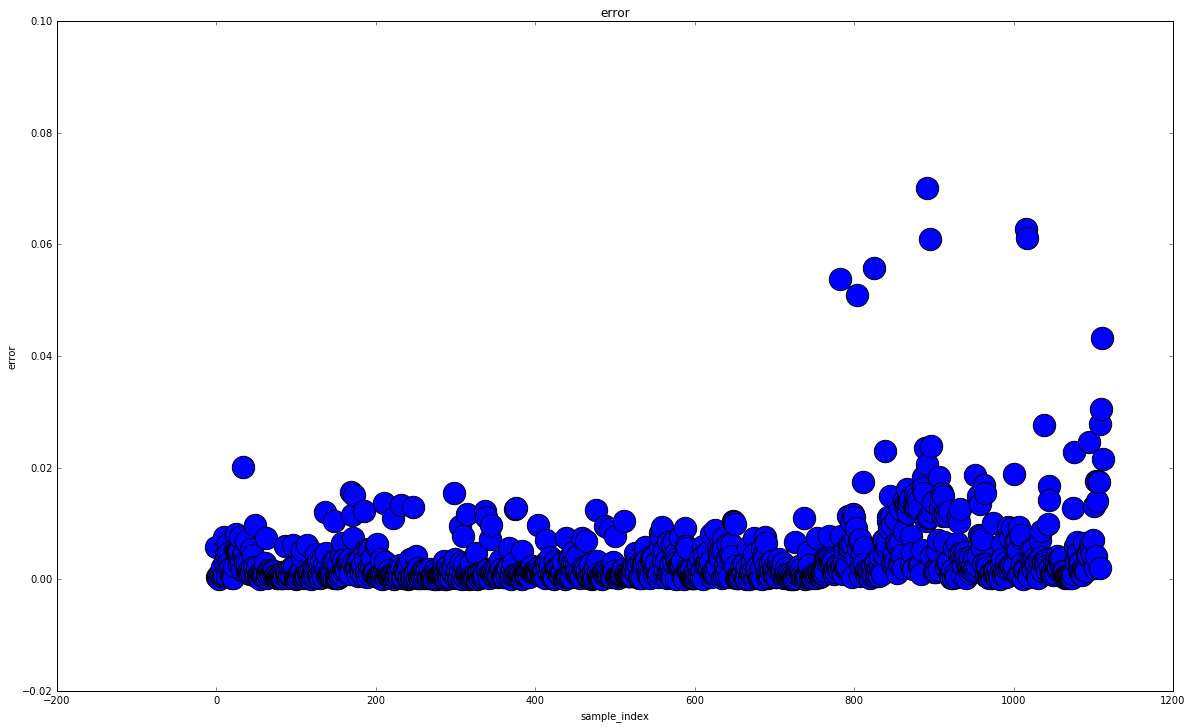

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

save_model = os.path.join(data_dir, 'tensorflow_model.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={x_data: scaled_dataset})
    print(test_batch_mse)
#     print(test_batch_mse)
#     for j,i in enumerate(test_batch_mse):
#         if i>800:
#             print(i,j)
    df_data=pd.DataFrame(test_batch_mse)
    
    print(df_data)
    df_data['sample_index']=df.index
    df_data.columns = ['error', 'sample_index']
    iqr_value=get_iqr(df_data)
    print(df_data)
    print(df_data)
    outliers=[]
    for i in range(0,len(df_data)):
        if df_data.iloc[i]['error']>iqr_value:
            outliers.append(df_data.iloc[i]['sample_index'])
    print(outliers)
        
    
    plt.figure()
    df_data.plot(kind="scatter", x="sample_index", y="error", 
        title = "error", s = 500)

# [14, 33, 37, 48, 62, 173, 185, 221, 232, 253, 260, 298, 343, 404, 428, 533, 535, 536, 545, 546, 547, 548, 
#  626, 629, 633, 645, 648, 649, 650, 674, 753, 754, 755, 756, 760, 761, 762, 763, 782, 784, 792, 799, 804, 
#  811, 821, 825, 836, 838, 839, 842, 843, 844, 845, 846, 863, 865, 867, 869, 870, 876, 879, 886, 887, 888, 
#  889, 891, 892, 893, 894, 895, 933, 985, 994, 1001, 1005, 1007, 1009, 1010, 1016, 1017, 1026, 1034, 1035, 
#  1037, 1038, 1044, 1075, 1076, 1080, 1081, 1089, 1094, 1095, 1101, 1103, 1105, 1106, 1107, 1108, 1109, 1110, 
#  1111, 1112]
# [11, 13, 81, 113, 125, 128, 134, 135, 173, 190, 206, 209, 211, 224, 229, 232, 235, 248, 259, 262, 267, 283, 314, 
#  318, 356, 378, 390, 396, 412, 449, 453, 463, 505, 514, 535, 546, 559, 562, 566, 583, 611, 628, 638, 644, 645, 660, 
#  709, 737, 751, 752, 777, 787, 805, 814, 818, 837, 844, 853, 858, 859, 866, 892, 895, 904, 905, 909, 913, 931, 932, 
#  936, 964, 967, 968, 980, 997, 1047, 1053, 1054, 1062, 1078, 1085, 1090, 1098, 1102]


# {'non_outliers': 1034, 'outliers_list': 
# [33, 48, 165, 166, 167, 172, 185, 232, 247, 343, 374, 376, 429, 491, 558, 
# 591, 611, 612, 615, 617, 646, 647, 648, 649, 650, 674, 683, 782, 804, 807, 810, 811, 821, 825, 826, 839, 845, 858, 
# 863, 886, 891, 892, 893, 894, 895, 897, 919, 940, 952, 956, 958, 963, 964, 1001, 1002, 1004, 1007, 1009, 1010, 1013, 
# 1014, 1016, 1017, 1034, 1035, 1038, 1076, 1089, 1094, 1095, 1103, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112], 
# 'outliers': 79}


In [ ]:
# [1113 rows x 2 columns]
# # [33.0, 48.0, 136.0, 147.0, 169.0, 170.0, 173.0, 185.0, 210.0, 221.0, 232.0, 247.0, 298.0, 305.0, 
# 315.0, 337.0, 338.0, 344.0, 374.0, 376.0, 404.0, 476.0, 488.0, 494.0, 511.0, 559.0, 588.0, 626.0, 
# 648.0, 649.0, 650.0, 737.0, 782.0, 792.0, 796.0, 799.0, 800.0, 802.0, 804.0, 811.0, 825.0, 839.0, 
# 842.0, 843.0, 844.0, 845.0, 846.0, 847.0, 852.0, 858.0, 863.0, 864.0, 865.0, 866.0, 867.0, 868.0, 
# 869.0, 870.0, 875.0, 876.0, 877.0, 878.0, 879.0, 880.0, 881.0, 886.0, 887.0, 888.0, 889.0, 890.0, 
# 891.0, 892.0, 893.0, 894.0, 895.0, 897.0, 898.0, 899.0, 907.0, 908.0, 909.0, 910.0, 911.0, 912.0,
# 914.0, 916.0, 919.0, 930.0, 931.0, 933.0, 952.0, 956.0, 958.0, 963.0, 964.0, 974.0, 993.0, 998.0, 
# 1001.0, 1007.0, 1016.0, 1017.0, 1038.0, 1043.0, 1044.0, 1045.0, 1075.0, 1076.0, 1095.0, 1101.0, 
# 1103.0, 1105.0, 1106.0, 1107.0, 1109.0, 1110.0, 1111.0, 1112.0]
